In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import xarray as xr

from tn_generative import lattices
from tn_generative import node_collections
from tn_generative import plotting_utils

In [2]:
home = os.path.expanduser("~")

In [3]:
# Turn off interactive mode to prevent automatic figure display
plt.ioff()

# Backup the original rcParams
original_rcparams = plt.rcParams.copy()

custom_rcparams = {
    'axes.labelsize': 18,     # Set the font size for axis labels
    'xtick.labelsize': 18,    # Set the font size for x-axis tick labels (customized)
    'ytick.labelsize': 18,    # Set the font size for y-axis tick labels  
    'font.size': 15,
    'legend.loc': 'upper right',
    'legend.markerscale': 2.,
    'text.usetex': True,
    'font.family':'Latin Modern Roman',
}

In [4]:
def update_ax_legend(ax, replacement_labels, loc='best', bbox_to_anchor=(1.05, 1.0)):
  # Replace legend labels
  handles, labels = ax.get_legend_handles_labels()
  new_labels = [replacement_labels.get(label, label) for label in labels]
  ax.legend(handles, new_labels, loc=loc, bbox_to_anchor=bbox_to_anchor)
  # Get the current x-axis label
  current_x_label = ax.get_xlabel()
  current_y_label = ax.get_ylabel()

  # Replace the x-axis label if it's in the dictionary
  new_x_label = replacement_labels.get(current_x_label, current_x_label)
  ax.set_xlabel(new_x_label)  
  # Replace the y-axis label if it's in the dictionary
  new_y_label = replacement_labels.get(current_y_label, current_y_label)
  ax.set_ylabel(new_y_label)
  ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
  return ax

legend_replacement_labels = {
    'model_bond_dim': 'bond dimension', 'data_kwargs_sampler': 'Scheme', 
    'data_num_training_samples': r'Samples $N$', 
    'training_training_schemes_lbfgs_reg_reg_kwargs_beta': r'$\beta$',
    'x_or_z_basis_sampler': 'Random-XZ', 'xz_basis_sampler': 'Global-XZ',
    'data_kwargs_system_size': r'System size $L$',
    'data_kwargs_size_x': r'System size $L_x$',
    'samples_threshold': 'Number of samples',
    'infidelity': r'Infidelity $1-F$',
    'data_kwargs_onsite_z_field': r'$h_z$',
    'training_training_schemes_lbfgs_reg_reg_kwargs_estimator': 'Estimator',
    'model_ll': r'Training NLL', 'test_ll': r'Test NLL', 
    'global_samples_threshold': 'Global fidelity', 'local_samples_threshold': 'Local fidelity'
}

Note: to run the following code, replace the corresponding `df_save_name` with the correct filepath for each figure

# Figure 2b: surfacec code $L_x \times L_y = 3\times3$

In [144]:
df_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_surface_code.csv')
df_load = pd.read_csv(df_save_name)
df_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_surface_code_regression.csv')
df_load_regression = pd.read_csv(df_save_name)

/var/folders/4m/mdyyxxqn7j36q10qw5j86hsh0000gp/T/ipykernel_19657/1077299176.py:60: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=colorbar_ticks)


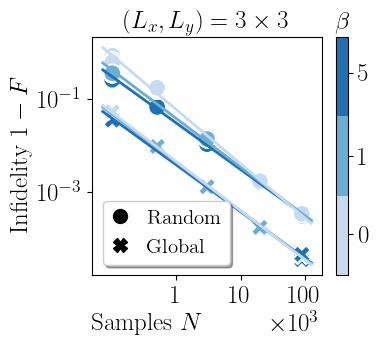

In [145]:
#@title Fix bondimension and look at regularization
plt.rcParams.update(custom_rcparams)

bright_palette = sns.color_palette('Blues', n_colors=df_load['training_training_schemes_lbfgs_reg_reg_kwargs_beta'].nunique())
plot_palette = {x: bright_palette[i] for i, x in enumerate(sorted(df_load['training_training_schemes_lbfgs_reg_reg_kwargs_beta'].unique()))}
n_cols = 1
n_rows = 1

panel_width = 3.7
panel_height = 3.1
fig, axarray = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height), squeeze=True)

fixed_bond_dimension = 10
system_size = 3
field = 0.
ax = axarray
plot_df = df_load.query('data_kwargs_size_x == @system_size and model_bond_dim == @fixed_bond_dimension\
                        and data_kwargs_onsite_z_field == @field')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    hue='training_training_schemes_lbfgs_reg_reg_kwargs_beta',
    palette=plot_palette,
    style='data_kwargs_sampler',
    ax=ax,
    s=150,
    legend=False, 
)
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()
for reg in plot_df['training_training_schemes_lbfgs_reg_reg_kwargs_beta'].unique():
  for sampler in plot_df['data_kwargs_sampler'].unique():
    reg_plot_df = df_load_regression.query(
        'data_kwargs_size_x == @system_size and training_training_schemes_lbfgs_reg_reg_kwargs_beta == @reg \
          and data_kwargs_sampler == @sampler and model_bond_dim == @fixed_bond_dimension \
          and data_kwargs_onsite_z_field == @field'
    )
    xs = np.linspace(*xlim)
    ys = np.exp(reg_plot_df['coefficient'].values * np.log(xs) + reg_plot_df['intercept'].values)
    ax.plot(xs, ys, c=plot_palette[reg], linewidth=2)
  ax.set_title(r'$(L_x, L_y)=3 \times 3$')
  
  update_ax_legend(ax, legend_replacement_labels, loc='best', bbox_to_anchor=(1., 1.), )
ax.set_xticks([1e3, 1e4, 1e5])  
legend_elements = [
    Line2D([0], [0], marker='o', color='k', markerfacecolor='k', label='Random', markersize=5, ls="none"),
    Line2D([0], [0], marker='X', color='k', markerfacecolor='k', label='Global', markersize=5, ls='none')]  
ax.legend(handles=legend_elements, loc='lower left', fancybox=True, shadow=True,  handlelength=0.9) 
ax.set_xlabel('Samples $N$', loc='left')
ax.ticklabel_format(axis='x',style='scientific',scilimits=(3,3), useMathText=True)

bounds = list(plot_palette.keys())
cmap = (mpl.colors.ListedColormap(list(plot_palette.values()))
        .with_extremes(under='yellow', over='magenta'))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
sm = mpl.cm.ScalarMappable(cmap=cmap)
colorbar_ticks = [0.175, 0.5, .85]
cbar = fig.colorbar(sm, ticks=colorbar_ticks)
cbar.ax.set_yticklabels(['0', '1', '5'])  # vertical colorbar
cbar.ax.set_title(r'$\beta$')



# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_b_scaling_3x3.pdf'), bbox_inches='tight')
plt.show()

# Figure 2c: fidelity scaling for strip geometry $L_y=3$ and field $h_z=0.1$

In [146]:
df_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_surface_code.csv')
df_load = pd.read_csv(df_save_name)

In [147]:
df_load['system_size'] = df_load['data_kwargs_size_x'] * df_load['data_kwargs_size_y']
system_sizes = np.unique(df_load['system_size'])
fidelity_thresholds = 0.99 ** system_sizes # Set the fidelity threshold to be 0.99^L

/Users/Yanting/Repositories/tn-shadow-qst/venv/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)
/var/folders/4m/mdyyxxqn7j36q10qw5j86hsh0000gp/T/ipykernel_19657/268593346.py:71: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=colorbar_ticks)


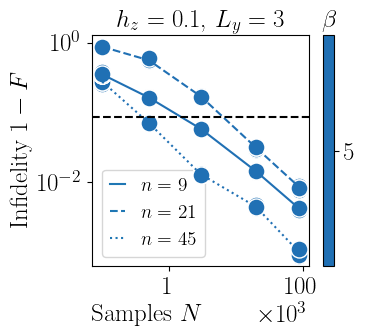

In [148]:
#@title Fix bondimension and look at regularization
plt.ioff()
plt.rcParams.update(custom_rcparams)

n_cols = 1
n_rows = 1

panel_width = 3.5
panel_height = 3.
fig, axarray = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height), squeeze=False)

fixed_bond_dimension = 10
field = 0.1
plot_system_sizes = [9, 21, 45]
plot_samplers = ['x_or_z_basis_sampler', ] #'xz_basis_sampler'
bright_palette = sns.palettes.color_palette('Blues', 3)
plot_palette = {x: bright_palette[2] for i, x in enumerate(sorted(plot_system_sizes))}
plot_linestyles = {9: 'dotted'  , 21: 'solid', 45:  'dashed'}
plot_regs = [5, ]
ax = axarray[0, 0]
for system_size in plot_system_sizes:
  for sampler in plot_samplers:
    plot_df = df_load.query('system_size == @system_size and \
                                 data_kwargs_onsite_z_field == @field and data_kwargs_sampler == @sampler and \
                                  training_training_schemes_lbfgs_reg_reg_kwargs_beta == 5')
    g = sns.scatterplot(
        data=plot_df,
        x='data_num_training_samples',
        y='infidelity',
        color=bright_palette[-1],
        linewidth=1,
        ax=ax,
        s=150,
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
    xlim = ax.get_xlim()

    for reg in plot_regs:
      plot_df_err = plot_df.query('training_training_schemes_lbfgs_reg_reg_kwargs_beta == @reg and \
          data_kwargs_sampler == @sampler and system_size == @system_size and data_kwargs_onsite_z_field ==  @field')
      plot_df_err = plot_df_err.sort_values(by='data_num_training_samples')
      plot_num_samples = (plot_df_err['data_num_training_samples'])
      plot_infidelity = (plot_df_err['infidelity_log_mean'])
      ax.plot(plot_num_samples, np.exp(plot_infidelity), color=plot_palette[system_size], linestyle=plot_linestyles[system_size])
      
      plot_error_max = np.exp(plot_df_err['infidelity_log_std'].values + plot_infidelity)
      plot_error_min = np.exp(-plot_df_err['infidelity_log_std'].values + plot_infidelity)
      ax.errorbar(plot_num_samples, np.exp(plot_infidelity), yerr=[np.exp(plot_infidelity)-plot_error_min, plot_error_max-np.exp(plot_infidelity)], 
                  fmt='none', color=plot_palette[system_size], zorder=1)      
      
      update_ax_legend(ax, legend_replacement_labels, loc='upper right')

for threshold in [fidelity_thresholds[0], ]:
  ax.axhline(1-threshold, xmin=0, xmax=1e5, color='k', linestyle='--')
ax.set_title(r'$h_z$'+ ' = {}, '.format(field) + r'$L_y=3$')
legend_elements = [
                   Line2D([0], [0], label=r'$n=9$', markersize=5, ls="solid"),
                   Line2D([0], [0], label=r'$n=21$', markersize=5, ls="dashed"),
                   Line2D([0], [0], label=r'$n=45$', markersize=5, ls="dotted"),
]  
ax.set_xlabel('Samples $N$', loc='left')
ax.ticklabel_format(axis='x',style='scientific',scilimits=(3,3), useMathText=True)

bounds = list(plot_palette.keys())
cmap = (mpl.colors.ListedColormap(list(plot_palette.values()))
        .with_extremes(under='yellow', over='magenta'))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
sm = mpl.cm.ScalarMappable(cmap=cmap)
colorbar_ticks = [0.5]
cbar = fig.colorbar(sm, ticks=colorbar_ticks)
cbar.ax.set_yticklabels(['5'])  # vertical colorbar
cbar.ax.set_title(r'$\beta$')

legend = ax.legend(handles=legend_elements, loc='lower left', fancybox=True, ncol=1, prop={'family': 'Latin Modern Roman', 'size': 14}, handlelength=0.8)
legend.set_zorder(-1)


# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_c_scaling_datasize.pdf'), bbox_inches='tight')
plt.show()

# Figure 2d: Scaling with system size

In [149]:
df_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_surface_code_sample_complexity.csv')
df_load = pd.read_csv(df_save_name)
size_y = df_load['size_y']

/var/folders/4m/mdyyxxqn7j36q10qw5j86hsh0000gp/T/ipykernel_19657/1166606439.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['system_size'] = size_y * plot_df['data_kwargs_size_x']
/var/folders/4m/mdyyxxqn7j36q10qw5j86hsh0000gp/T/ipykernel_19657/1166606439.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=colorbar_ticks)


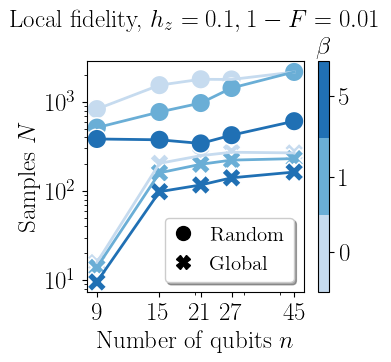

In [150]:
#@title Compute sample complexity as a function of system size for achieving fidelity threshold
plt.rcParams.update(custom_rcparams)
n_cols = 1
n_rows = 1

bright_palette = sns.color_palette('Blues', n_colors=df_load['training_training_schemes_lbfgs_reg_reg_kwargs_beta'].nunique())
plot_palette = {x: bright_palette[i] for i, x in enumerate(sorted(df_load['training_training_schemes_lbfgs_reg_reg_kwargs_beta'].unique()))}

panel_width = 3.5
panel_height = 3
fig, axarray = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height))

threshold = 0.01
fidelity_threshold_type = 'local_samples_threshold'
field = 0.1
bond = 10
plot_df = df_load.query(f'data_kwargs_onsite_z_field=={field} and infidelity_threshold == @threshold')
plot_df['system_size'] = size_y * plot_df['data_kwargs_size_x']
ax = axarray
for sampler in plot_df['data_kwargs_sampler'].unique():

  g = sns.lineplot(
      data=plot_df.query('data_kwargs_sampler == @sampler'),
      x='system_size',
      y=fidelity_threshold_type,
      hue='training_training_schemes_lbfgs_reg_reg_kwargs_beta',
      palette=plot_palette,
      ax=ax,
      linewidth=2,
      legend=False,
  )
g = sns.scatterplot(
    data=plot_df,
    x='system_size',
    y=fidelity_threshold_type,
    hue='training_training_schemes_lbfgs_reg_reg_kwargs_beta',
    palette=plot_palette,
    style='data_kwargs_sampler',
    ax=ax,
    s=200,
)    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'{legend_replacement_labels[fidelity_threshold_type]}, $h_z = {field}, 1 - F = {threshold}$', pad=25)
ax.set_xlabel('Number of qubits $n$')
ax.set_ylabel('Samples $N$')

update_ax_legend(ax, legend_replacement_labels, loc='best', bbox_to_anchor=None)

ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.set_xticks([9, 15, 21, 27, 45])
    

legend_elements = [
                   Line2D([0], [0], marker='o', color='k', markerfacecolor='k', label='Random', markersize=5, ls='none'),
                   Line2D([0], [0], marker='X', color='k', markerfacecolor='k', label='Global', markersize=5, ls='none')]  
ax.legend(handles=legend_elements, loc='lower right', fancybox=True, shadow=True, handlelength=1)              

bounds = list(plot_palette.keys())
cmap = (mpl.colors.ListedColormap(list(plot_palette.values()))
        .with_extremes(under='yellow', over='magenta'))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
sm = mpl.cm.ScalarMappable(cmap=cmap)
colorbar_ticks = [0.175, 0.5, .85]
cbar = fig.colorbar(sm, ticks=colorbar_ticks)
cbar.ax.set_yticklabels(['0', '1', '5'])  # vertical colorbar
cbar.ax.set_title(r'$\beta$')


# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_d_scaling_nqubits.pdf'), bbox_inches='tight')
plt.show()

# Figure 3c: fidelity scaling for ruby pxp $\delta=1.7$

In [151]:
df_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig3_ruby_0314.csv')
df_load = pd.read_csv(df_save_name)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


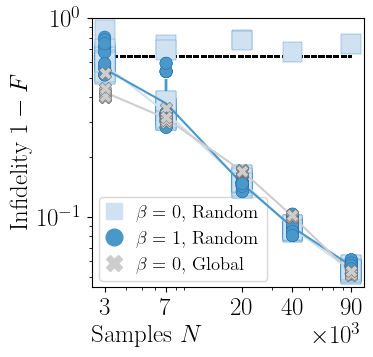

In [152]:
#@title Plot
plt.ioff()
plt.rcParams.update(custom_rcparams)

n_cols = 1
n_rows = 1

panel_width = 3.5
panel_height = 3.5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height))

# Random XZ figure
fixed_bond_dimension = 20
delta = 1.7
sampler = 'x_or_z_basis_sampler'
plot_regs = [0., 1.,]
bright_palette = sns.color_palette('Blues', n_colors=4)
plot_palette = {x: bright_palette[i] for i, x in enumerate(plot_regs)}
plot_palette = {
    0: bright_palette[0],
    1: bright_palette[2]
}
plot_color = np.array([205, 205, 205]) / 255
edge_color = 'dimgrey'
xmin = 3e3
xmax = 90_000
ax.hlines(1-df_load['fidelity_threshold'], xmin, xmax, color='k', linestyle='--', linewidth=1)
plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension and \
                         training_training_schemes_lbfgs_reg_reg_kwargs_beta == 0')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    marker='s',
    palette=plot_palette,
    hue='training_training_schemes_lbfgs_reg_reg_kwargs_beta',
    linewidth=0.3,
    ax=ax,
    s=200,
    edgecolor=bright_palette[2],
    zorder=2,
)
plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension and \
                         training_training_schemes_lbfgs_reg_reg_kwargs_beta == 1')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    marker='o',
    palette=plot_palette,
    hue='training_training_schemes_lbfgs_reg_reg_kwargs_beta',
    linewidth=0.3,
    ax=ax,
    s=80,
    edgecolor=bright_palette[3],
    zorder=3
)
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()

# Error bars for random XZ
plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension and \
                         training_training_schemes_lbfgs_reg_reg_kwargs_beta < 5')                              
for reg in plot_regs:
  plot_df_err = plot_df.query('training_training_schemes_lbfgs_reg_reg_kwargs_beta == @reg and \
      data_kwargs_sampler == @sampler and data_kwargs_delta ==  @delta')
  plot_df_err = plot_df_err.dropna(subset=['infidelity_mean'])
  plot_df_err = plot_df_err.sort_values(by='data_num_training_samples')
  plot_num_samples = (plot_df_err['data_num_training_samples'])

  plot_infidelity = (plot_df_err['infidelity_log_mean'])
  ax.plot(plot_num_samples, np.exp(plot_infidelity), color=plot_palette[reg])
  plot_error_max = np.exp(plot_df_err['infidelity_log_std'].values + plot_infidelity)
  plot_error_min = np.exp(-plot_df_err['infidelity_log_std'].values + plot_infidelity)
  ax.errorbar(plot_num_samples, np.exp(plot_infidelity), yerr=[np.exp(plot_infidelity)-plot_error_min, plot_error_max-np.exp(plot_infidelity)], 
              fmt='none', color=plot_palette[reg], zorder=0)
  

# Fixed XZ figure
fixed_bond_dimension = 20
sampler = 'xz_basis_sampler'
reg = 0.
red_color = np.array([159, 25, 14])/255
plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    marker='X',
    c=plot_color,
    linewidth=0.3,
    ax=ax,
    s=80,
    edgecolor=edge_color, 
    zorder=4
)
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()


plot_df_err = plot_df.query('training_training_schemes_lbfgs_reg_reg_kwargs_beta == @reg and \
    data_kwargs_sampler == @sampler and data_kwargs_delta ==  @delta')
plot_df_err = plot_df_err.dropna(subset=['infidelity_mean'])
plot_df_err = plot_df_err.sort_values(by='data_num_training_samples')
plot_num_samples = (plot_df_err['data_num_training_samples'])

plot_infidelity = (plot_df_err['infidelity_log_mean'])
plot_error_max = np.exp(plot_df_err['infidelity_log_std'].values + plot_infidelity)
plot_error_min = np.exp(-plot_df_err['infidelity_log_std'].values + plot_infidelity)
ax.plot(plot_num_samples, np.exp(plot_infidelity), color=plot_color)
ax.errorbar(plot_num_samples, np.exp(plot_infidelity), yerr=[np.exp(plot_infidelity)-plot_error_min, plot_error_max-np.exp(plot_infidelity)], 
            fmt='none', color=plot_color, zorder=1)

update_ax_legend(ax, legend_replacement_labels, loc='upper right')
ax.set_xticks([ 3000,  7000, 20000, 40000, 90000])
legend_elements = [
                   Line2D([0], [0], marker='s', color=plot_palette[0], markerfacecolor=plot_palette[0], lw=2.5, label=r'$\beta = 0$, Random', ls='none'),
                   Line2D([0], [0], marker='o', color=plot_palette[1.], markerfacecolor=plot_palette[1], lw=2.5, label=r'$\beta = 1$, Random', ls='none'),
                   Line2D([0], [0], marker='X', color=plot_color, markerfacecolor=plot_color, lw=2.5, label=r'$\beta=0$, Global', ls='none')
                  ]  
ax.set_xlabel('Samples $N$', loc='left')
ax.ticklabel_format(axis='x',style='scientific',scilimits=(3,3), useMathText=True)

legend = ax.legend(handles=legend_elements, bbox_to_anchor=(0.68, 0.37), fancybox=True, ncol=1, prop={'family': 'Latin Modern Roman', 'size':13.5}, handlelength=0.8)
legend.set_zorder(-1)
# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig3_c_scaling_datasize_sl.pdf'), bbox_inches='tight')
plt.show()

# Figure 3d: fidelity scaling for ruby pxp $\delta=0.5$

In [153]:
df_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig3_ruby_0314.csv')
df_load = pd.read_csv(df_save_name)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


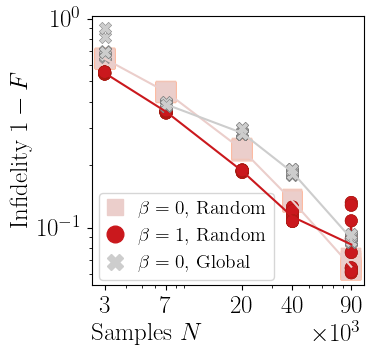

In [154]:
#@title Plot
plt.ioff()
plt.rcParams.update(custom_rcparams)

n_cols = 1
n_rows = 1

panel_width = 3.5
panel_height = 3.5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height))

# Random XZ figure
fixed_bond_dimension = 30
delta = 0.5
sampler = 'x_or_z_basis_sampler'
plot_regs = [0., 1.,]
bright_palette = sns.color_palette('Reds', n_colors=3)
dark_red = np.array([159, 25, 14]) / 255
plot_palette = {
  0: np.array([235, 206, 203]) / 255,
    1: bright_palette[2],
}
plot_color = np.array([205, 205, 205]) / 255
edge_color = 'dimgrey'
plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension and \
                         training_training_schemes_lbfgs_reg_reg_kwargs_beta == 0')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    marker='s',
    palette=plot_palette,
    hue='training_training_schemes_lbfgs_reg_reg_kwargs_beta',
    linewidth=0.2,
    ax=ax,
    s=200,
    edgecolor=bright_palette[0],
)

plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension and \
                         training_training_schemes_lbfgs_reg_reg_kwargs_beta == 1')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    marker='o',
    palette=plot_palette,
    hue='training_training_schemes_lbfgs_reg_reg_kwargs_beta',
    linewidth=0.3,
    ax=ax,
    s=80,
    edgecolor=dark_red,
)
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()

plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension and \
                         training_training_schemes_lbfgs_reg_reg_kwargs_beta < 5')

for reg in plot_regs:
  plot_df_err = plot_df.query('training_training_schemes_lbfgs_reg_reg_kwargs_beta == @reg and \
      data_kwargs_sampler == @sampler and data_kwargs_delta ==  @delta')
  plot_df_err = plot_df_err.dropna(subset=['infidelity_mean'])
  plot_df_err = plot_df_err.sort_values(by='data_num_training_samples')
  plot_num_samples = (plot_df_err['data_num_training_samples'])

  plot_infidelity = (plot_df_err['infidelity_log_mean'])
  ax.plot(plot_num_samples, np.exp(plot_infidelity), color=plot_palette[reg])
  plot_error_max = np.exp(plot_df_err['infidelity_log_std'].values + plot_infidelity)
  plot_error_min = np.exp(-plot_df_err['infidelity_log_std'].values + plot_infidelity)
  ax.errorbar(plot_num_samples, np.exp(plot_infidelity), yerr=[np.exp(plot_infidelity)-plot_error_min, plot_error_max-np.exp(plot_infidelity)], 
              fmt='none', color=plot_palette[reg], zorder=0)  
  

# Fixed XZ figure
sampler = 'xz_basis_sampler'
reg = 0.
plot_df = df_load.query('data_kwargs_delta == @delta and data_kwargs_sampler == @sampler and \
                        model_bond_dim == @fixed_bond_dimension')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    marker='X',
    c=plot_color,
    linewidth=0.3,
    ax=ax,
    s=80,
    edgecolor=edge_color
)
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()

plot_df_err = plot_df.query('training_training_schemes_lbfgs_reg_reg_kwargs_beta == @reg and \
    data_kwargs_sampler == @sampler and data_kwargs_delta ==  @delta')
plot_df_err = plot_df_err.dropna(subset=['infidelity_mean'])
plot_df_err = plot_df_err.sort_values(by='data_num_training_samples')
plot_num_samples = (plot_df_err['data_num_training_samples'])

plot_infidelity = (plot_df_err['infidelity_log_mean'])
plot_error_max = np.exp(plot_df_err['infidelity_log_std'].values + plot_infidelity)
plot_error_min = np.exp(-plot_df_err['infidelity_log_std'].values + plot_infidelity)
ax.plot(plot_num_samples, np.exp(plot_infidelity), color=plot_color)
ax.errorbar(plot_num_samples, np.exp(plot_infidelity), yerr=[np.exp(plot_infidelity)-plot_error_min, plot_error_max-np.exp(plot_infidelity)], 
            fmt='none', color=plot_color, zorder=1)

update_ax_legend(ax, legend_replacement_labels, loc='upper right')
# ax.set_title(r'$\Delta / \Omega$'+ ' = {}'.format(delta))
ax.set_xticks([ 3000,  7000, 20000, 40000, 90000])

legend_elements = [
                   Line2D([0], [0], marker='s', color=plot_palette[0], markerfacecolor=plot_palette[0], lw=2.5, label=r'$\beta = 0$, Random', ls='none'),
                   Line2D([0], [0], marker='o', color=plot_palette[1.], markerfacecolor=plot_palette[1], lw=2.5, label=r'$\beta = 1$, Random', ls='none'),
                   Line2D([0], [0], marker='X', color=plot_color, markerfacecolor=plot_color, lw=2.5, label=r'$\beta=0$, Global', ls='none')
                  ]  
ax.set_xlabel('Samples $N$', loc='left')
ax.ticklabel_format(axis='x',style='scientific',scilimits=(3,3), useMathText=True)

# 
legend = ax.legend(handles=legend_elements, bbox_to_anchor=(0.705, 0.38), fancybox=True, ncol=1, prop={'family': 'Latin Modern Roman', 'size':14}, handlelength=0.8)
legend.set_zorder(-1)

# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig3_d_scaling_datasize_disorder.pdf'), bbox_inches='tight')
plt.show()

# Figure 4c: P strings for ruby pxp $\delta=1.7$

In [155]:
ds_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig4_rydberg_p_strings.nc')
ds_load = xr.load_dataset(ds_save_name)

In [156]:
nums_samples = [3000, 7000, 20_000, 40_000, 90_000]
bright_palette = sns.color_palette('Blues', n_colors=len(nums_samples))
plot_palette = {x: bright_palette[i] for i, x in enumerate(nums_samples)}
plot_palette = {
    'p_bffm': np.array([159, 25, 14])/255, 
    'p_loop': np.array([0.1271049596309112, 0.4401845444059977, 0.7074971164936563]),
}

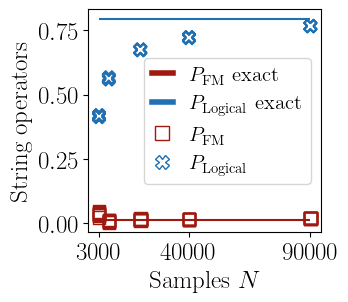

In [ ]:
plt.rcParams.update(custom_rcparams)
n_cols = 1
n_rows = 1

panel_width = 3.
panel_height = 2.9
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height))

for seed in range(9):
  plot_ds = ds_load.sel(seed=seed)
  ax.scatter(plot_ds['num_samples'], plot_ds['p_bffm_trained'], label='P_BFFM', marker='s', facecolor='none', edgecolor=plot_palette['p_bffm'], s=80)
  ax.scatter(plot_ds['num_samples'], plot_ds['p_loop_trained'], label='P_loop', marker='X', facecolor='none', edgecolor=plot_palette['p_loop'], s=80)
ax.hlines(ds_load['p_bffm'], ds_load['num_samples'].min(), ds_load['num_samples'].max(), label='P BFFM exact', color=plot_palette['p_bffm'])
ax.hlines(ds_load['p_loop'], ds_load['num_samples'].min(), ds_load['num_samples'].max(), label='P logical exact', color=plot_palette['p_loop'])
ax.set_xlabel('Samples $N$')
ax.set_ylabel('String operators')
ax.set_xticks([ 3000, 40000, 90000])
# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig4_d_strings.pdf'), bbox_inches='tight')
plt.show()

# Figure 4d/e: entanglement entropy for ruby pxp $\delta=1.7$

In [158]:
ds_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig4_rydberg_entanglement.nc')
ds_load = xr.load_dataset(ds_save_name)

In [159]:
nums_samples = [3000, 7000, 20_000, 40_000, 90_000]
bright_palette = sns.color_palette('Blues', n_colors=len(nums_samples))
plot_palette = {x: bright_palette[i] for i, x in enumerate(nums_samples)}
red_color = np.array([159, 25, 14])/255 

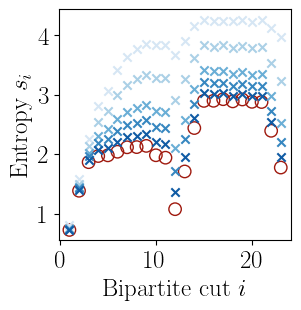

In [160]:
plt.rcParams.update(custom_rcparams)
n_cols = 1
n_rows = 1

panel_width = 3.
panel_height = 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height))

ax.scatter(ds_load['L'], ds_load['entropy'], label='Exact', marker='o', facecolor='none', edgecolors=red_color, s=80)  
for num_samples in nums_samples:
  ax.scatter(ds_load['L'], ds_load.sel(num_samples=num_samples)['entropy_trained'], label=f'$m=${num_samples}', marker='x', color=plot_palette[num_samples])
  ax.set_xlabel(r'Bipartite cut $i$')
  ax.set_ylabel(r'Entropy $s_i$')
# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig4_a_entropy.pdf'), bbox_inches='tight')
plt.show()

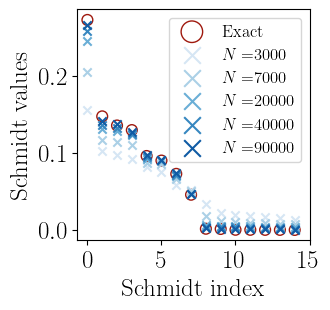

In [161]:
plt.rcParams.update(custom_rcparams)
schmidt_ranges = 15

n_cols = 1
n_rows = 1

panel_width = 3
panel_height = 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height))

ax.scatter(ds_load['bond'][:schmidt_ranges], ds_load['schmidt_vals'][:schmidt_ranges], label='Exact', marker='o', facecolor='none', edgecolors=red_color, s=60)
for num_samples in nums_samples:
  ax.scatter(ds_load['bond_trained'][:schmidt_ranges], ds_load.sel(num_samples=num_samples)['schmidt_vals_trained'][:schmidt_ranges], label=f'$N=${num_samples}', marker='x', color=plot_palette[num_samples])
  ax.set_xticks([0, 5, 10, 15])
  ax.set_xlabel('Schmidt index')
  ax.set_ylabel('Schmidt values')
  ax.legend(fontsize=12)
# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig4_b_schmidt.pdf'), bbox_inches='tight')
plt.show()

# Supplementary Figure 1 -  Appendix B

In [162]:
ds_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'mle_results_ghz_random_3qubits_combined.nc')
ds_load = xr.load_dataset(ds_save_name)

/var/folders/4m/mdyyxxqn7j36q10qw5j86hsh0000gp/T/ipykernel_19657/1625891069.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=colorbar_ticks)


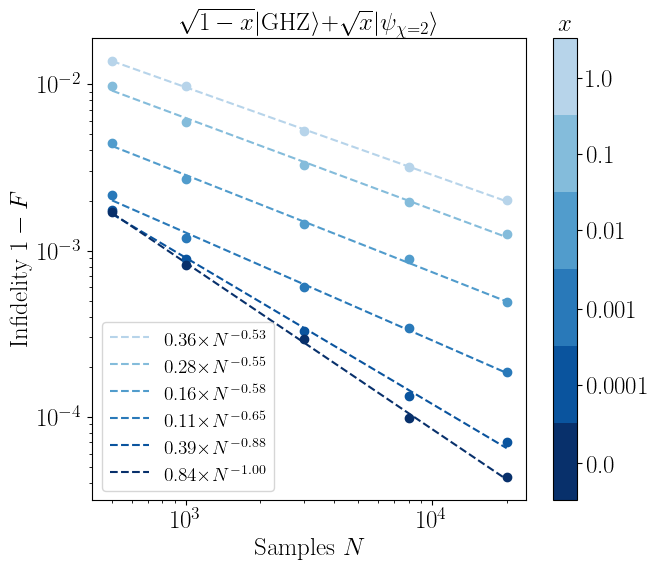

In [163]:
# plot fidelity scaling with training samples for different x
plt.rcParams.update(custom_rcparams)
cmap = sns.color_palette("Blues", as_cmap=True)
colors = cmap(np.linspace(0.3, 1, ds_load.random_ratio_x.size))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
for i, x in enumerate((ds_load.random_ratio_x.values)):
  c = colors[i]
  mle_results = ds_load.sel(random_ratio_x=x)
  mle_results['1-fidelity'] = 1 - mle_results.where(mle_results.fidelity > 0.9, drop=True).fidelity
  slopef, interceptf = np.polyfit(np.log(mle_results.train_samples), np.log(mle_results['1-fidelity'].mean(axis=0)), 1)
  ax.errorbar(mle_results.train_samples, mle_results["1-fidelity"].mean(axis=0), marker='o',
              linestyle='none', label='_nolegend_', c=c,
              yerr=mle_results["1-fidelity"].std(axis=0) / np.sqrt(ds_load.rand_seed.size),
              )
  ax.plot(mle_results.train_samples, np.exp(interceptf) * mle_results.train_samples**slopef, label=f'{np.exp(interceptf):.2f}'+r'$\times $'+ f'$N^{{{slopef:.2f}}}$',
          linestyle='--', c=c, )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Samples $N$')
ax.set_ylabel(r'Infidelity $1-F$')
ax.set_title('$\sqrt{1-x}$'+ r'$|\mathrm{GHZ}\rangle + $' + '$\sqrt{x}$' + r'$|\psi_{\chi=2}\rangle$')
ax.legend(loc='lower left', fontsize=14)


bounds = np.flip(ds_load.random_ratio_x.values)
cmap = (mpl.colors.ListedColormap(colors[::-1])) # list of colors (ordered from low to high)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
sm = mpl.cm.ScalarMappable(cmap=cmap)
colorbar_ticks = [0.08, 0.25, 0.415, 0.585, 0.75, 0.915]
cbar = fig.colorbar(sm, ticks=colorbar_ticks)
cbar.ax.set_yticklabels(list(np.flip(ds_load.random_ratio_x.values)))  # vertical colorbar
cbar.ax.set_title(r'$x$')
# 
# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig_appendix_b_scaling.pdf'), bbox_inches='tight')
plt.show()

# Supplementary Figure 2 - Appendix F: ruby pxp model

In [164]:
ds_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'rydberg_snapshot.nc')
ds_load = xr.load_dataset(ds_save_name)

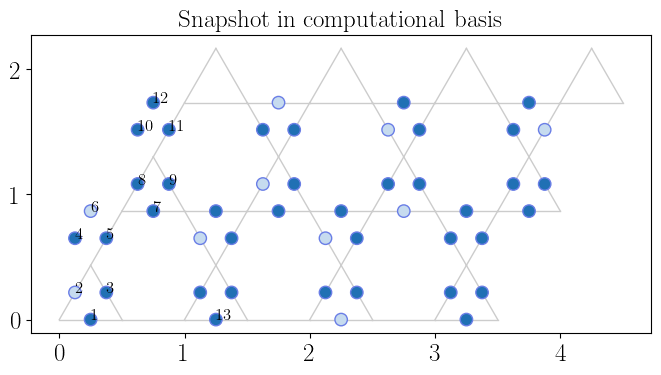

In [165]:
size_x = 4
size_y = 2
expanded_lattice = lattices.RubyLattice().get_expanded_lattice(size_x=size_x, size_y=size_y)
kagome_lat = lattices.KagomeLattice().get_expanded_lattice(size_x=4, size_y=3).shift(np.array([0.25, 0.]))
bonds = node_collections.get_nearest_neighbors(kagome_lat, 0.51)

plt.rcParams.update(custom_rcparams)
plot_palette = {
    0: np.array([0.7752402921953095, 0.8583006535947711, 0.9368242983467897]), 
    1: np.array([0.1271049596309112, 0.4401845444059977, 0.7074971164936563]),
}
edge_color = np.array([106 / 255, 126 / 255, 230 / 255])
annotate = True
annotate_range = 13
n_cols = 1
n_rows = 1
fig, ax = plt.subplots(n_cols, n_rows, figsize=(8 * n_rows, 6 * n_cols))
color = ds_load.measurement.isel(sample=0).values
plotting_utils.plot_bonds(bonds, ax, lw=1, c='0.8')
lattice_color = [plot_palette[c] for c in color]
ax.scatter(*expanded_lattice.points.T, c=lattice_color, s=80, alpha=1., zorder=2, edgecolors=edge_color)
if annotate:
  for i in range(annotate_range):
    ax.annotate(str(i+1), expanded_lattice.points[i], fontsize=12)  
ax.set_yticks([0, 1, 2])
ax.set_aspect("equal")
ax.set_title(f"Snapshot in computational basis")

# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig_e_2_rydberg.pdf'), bbox_inches='tight')
plt.show()

# Supplementary Figure 3 - Appendix G: Model selection by training and test NLL
 - surfacec code for different $L_x$

In [166]:
df_save_name = os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig2_surface_code.csv') 
df_load = pd.read_csv(df_save_name)

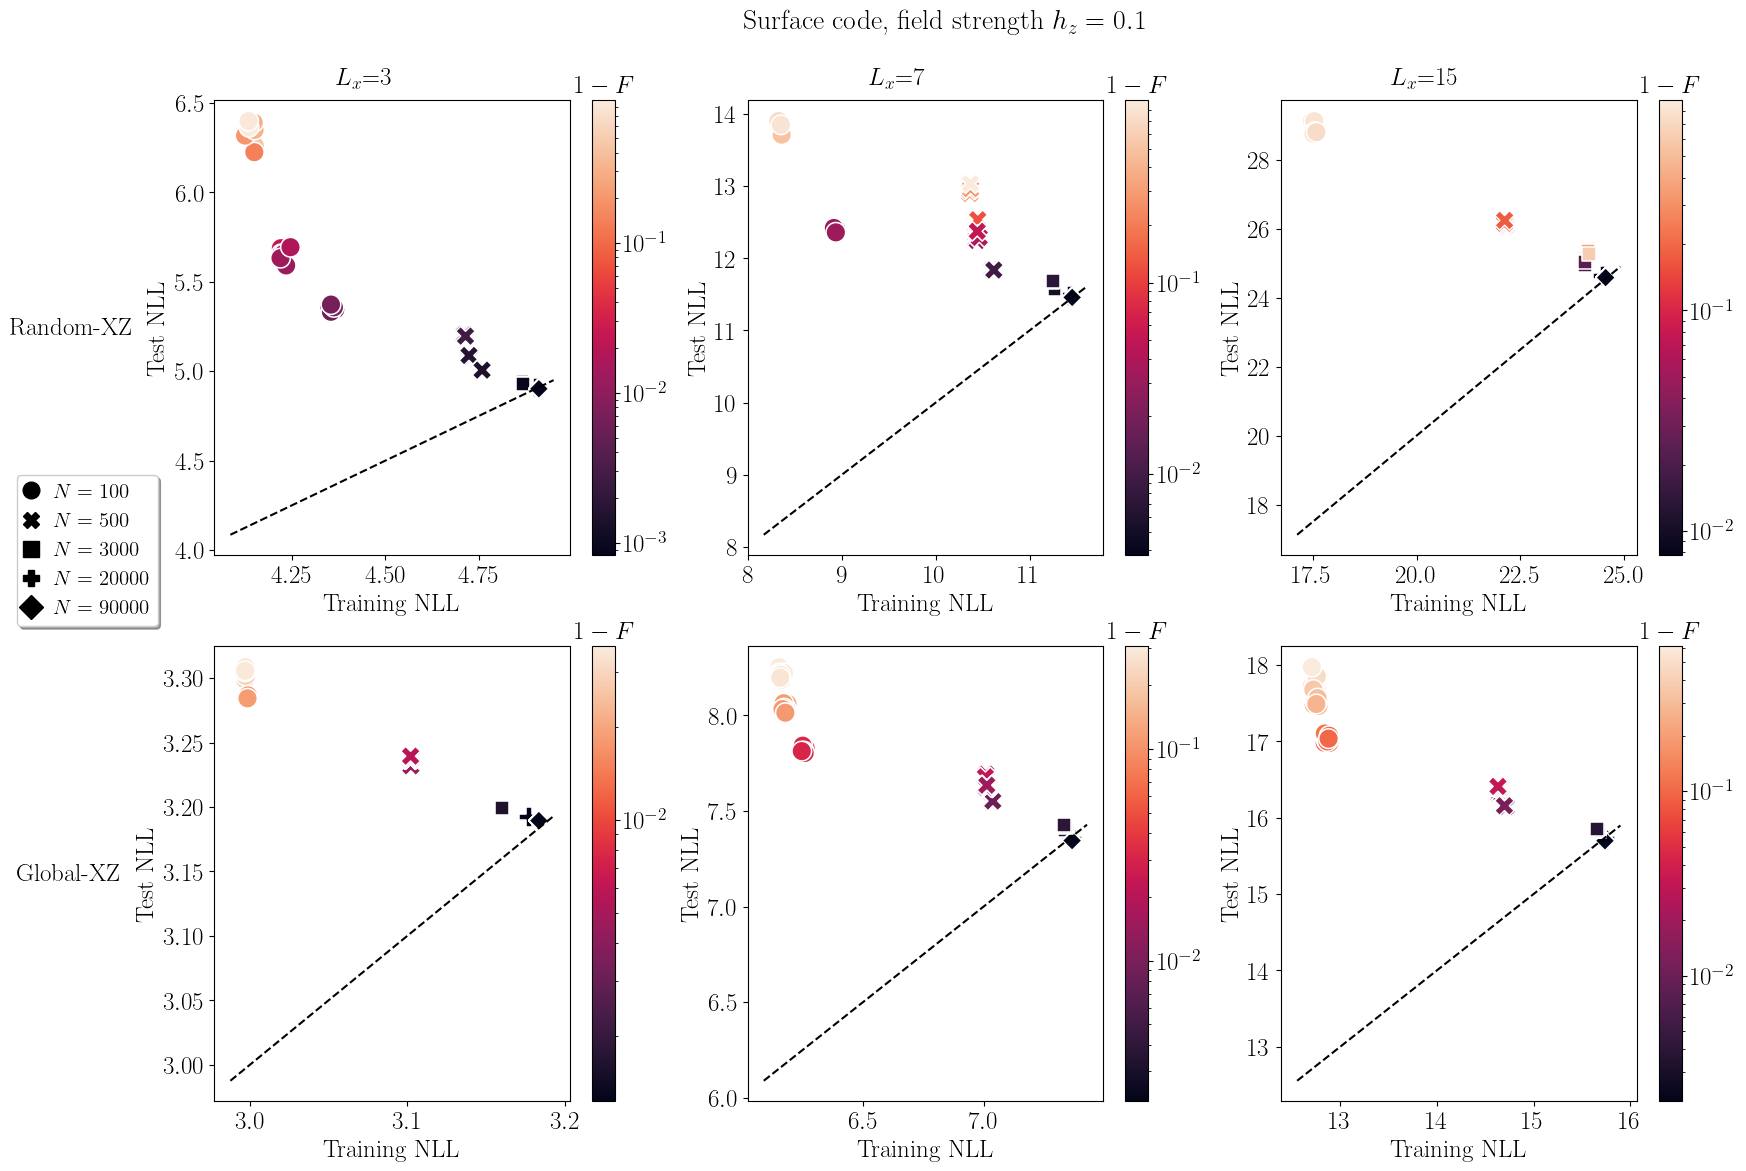

In [167]:
#@title Show that we can select the models that generalize by its test and training score
plt.rcParams.update(custom_rcparams)
unique_system_sizes = [3, 7, 15]
unique_samplers = sorted(df_load['data_kwargs_sampler'].unique())
n_cols = len(unique_system_sizes)
n_rows = len(unique_samplers)

panel_width = 6.5
panel_height = 6.5
fixed_test_model_ratio = 1.
test_offset = 0.5
test_model_ratio_thresholds = {(size, sampler): fixed_test_model_ratio for size in unique_system_sizes for sampler in unique_samplers}
field = 0.1
fig, axarray = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height))
for i, sampler in enumerate(unique_samplers):
  for j, system_size in enumerate(unique_system_sizes):
    ax = axarray[i, j]
    plot_df = df_load.query('data_kwargs_size_x == @system_size and data_kwargs_sampler == @sampler \
                       and data_kwargs_onsite_z_field == @field and data_num_training_samples < 99000')
    g = sns.scatterplot(
        data=plot_df,
        x='model_ll',
        y='test_ll',
        hue='infidelity',
        palette='rocket',
        style='data_num_training_samples',
        ax=ax,
        s=200,
    )
    xlim = ax.get_xlim()
    xs = np.linspace(*xlim, 100)
    ys = fixed_test_model_ratio * xs
    ax.plot(xs, ys, 'k--')
    
    update_ax_legend(ax, legend_replacement_labels, loc='lower left', bbox_to_anchor=(0., 0.))
    ax.get_legend().remove()
    norm = mpl.colors.LogNorm(plot_df['infidelity'].min(), plot_df['infidelity'].max())
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    sm.set_array([])

    # Create the colorbar for this subplot
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')  # or 'horizontal'
    cbar.ax.set_title('$1 - F$')

fig.suptitle(f'Surface code, field strength $h_z = {field}$', fontsize=20, y=0.95)
pad = 6 # in points
rows_label = [legend_replacement_labels[k] for k in unique_samplers]
for ax, row in zip(axarray[:,0], rows_label):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
cols_label = [f'$L_x$={size_x}' for size_x in unique_system_sizes]
for ax, col in zip(axarray[0, :], cols_label):
    ax.annotate(col, xy=(0, 0.5), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords=ax.title, textcoords='offset points',
                size='large', ha='right', va='center')


legend_elements = [
                   
                   Line2D([0], [0], marker='o', c='k', lw=2.5, label=r'$N=100$', ls='none'),
                   Line2D([0], [0], marker='X', c='k', lw=2.5, label=r'$N=500$', ls='none'),
                   Line2D([0], [0], marker='s', c='k', lw=2.5, label=r'$N=3000$', ls='none'),
                   Line2D([0], [0], marker='P', c='k', lw=2.5, label=r'$N=20000$', ls='none'),
                   Line2D([0], [0], marker='D', c='k', lw=2.5, label=r'$N=90000$', ls='none'),
                  ]  
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.06, 0.6), fancybox=True, shadow=True, prop={'family': 'Latin Modern Roman'}, handlelength=0.5)

# Save the data for this figure
# plt.savefig(os.path.join(home, 'tn_shadow_dir/Draft/figures_results/', 'fig_appedix_e2_sc_lx_train_test_nll.pdf'), bbox_inches='tight')
plt.show()


# Supplementary Figure 4

In [6]:
df_save_name = os.path.join(home, 'tn_shadow_dir/surface_code_3x3_bond10_noise_eval.csv') 
df_load = pd.read_csv(df_save_name)

/var/folders/6l/6swmzdw53rxftwwp5c3b2frw0000gn/T/ipykernel_44739/941801881.py:51: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=colorbar_ticks)


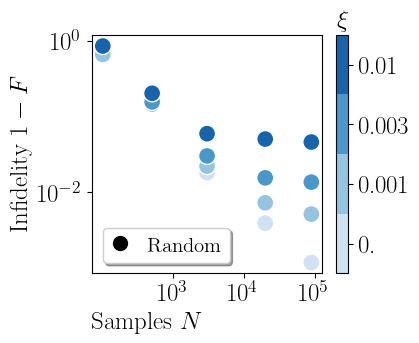

In [ ]:
#@title Fix bondimension and look at regularization
plt.rcParams.update(custom_rcparams)

bright_palette = sns.color_palette('Blues', n_colors=df_load['training_data_noise_probabilities'].nunique())
noise_probabilities = [0., 0.001, 0.003, 0.01]
plot_palette = {x: bright_palette[i] for i, x in enumerate(sorted(df_load['training_data_noise_probabilities'].unique()))}
n_cols = 1
n_rows = 1

panel_width = 3.7
panel_height = 3.1
fig, axarray = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height), squeeze=True)

fixed_bond_dimension = 10
system_size = 3
field = 0.1
ax = axarray
plot_df = df_load.query('data_kwargs_size_x == @system_size and model_bond_dim == @fixed_bond_dimension\
                        and data_kwargs_onsite_z_field == @field and current_sequence == "lbfgs_1"')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    hue='training_data_noise_probabilities',
    palette=plot_palette,
    # style='data_kwargs_sampler',
    ax=ax,
    s=150,
    legend=False, 
)
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()

ax.set_xticks([1e3, 1e4, 1e5])  
legend_elements = [
    Line2D([0], [0], marker='o', color='k', markerfacecolor='k', label='Random', markersize=5, ls="none"),
    # Line2D([0], [0], marker='X', color='k', markerfacecolor='k', label='Global', markersize=5, ls='none')
  ]  
ax.legend(handles=legend_elements, loc='lower left', fancybox=True, shadow=True,  handlelength=0.9) 
ax.set_xlabel('Samples $N$', loc='left')
ax.set_ylabel('Infidelity $1-F$')
# ax.ticklabel_format(axis='x',style='scientific',scilimits=(3,3), useMathText=True)

bounds = [x for x in noise_probabilities]
cmap = (mpl.colors.ListedColormap(list(plot_palette.values()))
        .with_extremes(under='yellow', over='magenta'))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
sm = mpl.cm.ScalarMappable(cmap=cmap)
colorbar_ticks = [0.125, 0.375, 0.625, .875]
cbar = fig.colorbar(sm, ticks=colorbar_ticks)
cbar.ax.set_yticklabels(['0.', '0.001', '0.003', '0.01'])  # vertical colorbar
cbar.ax.set_title(r'$\xi$')



# plt.savefig(os.path.join(home, 'tn_shadow_dir/', 'supp_fig4_noise.pdf'), bbox_inches='tight')
plt.show()

In [44]:
df_save_name = os.path.join(home, 'tn_shadow_dir/surface_code_3x3_bond10_xz_xorz_noise_eval.csv') 
df_load = pd.read_csv(df_save_name)

/var/folders/6l/6swmzdw53rxftwwp5c3b2frw0000gn/T/ipykernel_44739/3939224375.py:51: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, ticks=colorbar_ticks)


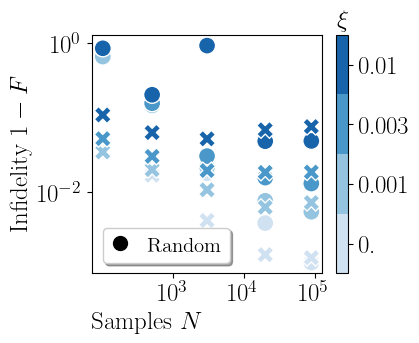

In [45]:
#@title Fix bondimension and look at regularization
plt.rcParams.update(custom_rcparams)

bright_palette = sns.color_palette('Blues', n_colors=df_load['training_data_noise_probabilities'].nunique())
noise_probabilities = [0., 0.001, 0.003, 0.01]
plot_palette = {x: bright_palette[i] for i, x in enumerate(sorted(df_load['training_data_noise_probabilities'].unique()))}
n_cols = 1
n_rows = 1

panel_width = 3.7
panel_height = 3.1
fig, axarray = plt.subplots(n_rows, n_cols, figsize=(n_cols * panel_width, n_rows * panel_height), squeeze=True)

fixed_bond_dimension = 10
system_size = 3
field = 0.1
ax = axarray
plot_df = df_load.query('data_kwargs_size_x == @system_size and model_bond_dim == @fixed_bond_dimension\
                        and data_kwargs_onsite_z_field == @field and current_sequence == "lbfgs_1"')
g = sns.scatterplot(
    data=plot_df,
    x='data_num_training_samples',
    y='infidelity',
    hue='training_data_noise_probabilities',
    palette=plot_palette,
    style='data_kwargs_sampler',
    ax=ax,
    s=150,
    legend=False, 
)
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()

ax.set_xticks([1e3, 1e4, 1e5])  
legend_elements = [
    Line2D([0], [0], marker='o', color='k', markerfacecolor='k', label='Random', markersize=5, ls="none"),
    # Line2D([0], [0], marker='X', color='k', markerfacecolor='k', label='Global', markersize=5, ls='none')
  ]  
ax.legend(handles=legend_elements, loc='lower left', fancybox=True, shadow=True,  handlelength=0.9) 
ax.set_xlabel('Samples $N$', loc='left')
ax.set_ylabel('Infidelity $1-F$')
# ax.ticklabel_format(axis='x',style='scientific',scilimits=(3,3), useMathText=True)

bounds = [x for x in noise_probabilities]
cmap = (mpl.colors.ListedColormap(list(plot_palette.values()))
        .with_extremes(under='yellow', over='magenta'))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
sm = mpl.cm.ScalarMappable(cmap=cmap)
colorbar_ticks = [0.125, 0.375, 0.625, .875]
cbar = fig.colorbar(sm, ticks=colorbar_ticks)
cbar.ax.set_yticklabels(['0.', '0.001', '0.003', '0.01'])  # vertical colorbar
cbar.ax.set_title(r'$\xi$')



# plt.savefig(os.path.join(home, 'tn_shadow_dir/', 'supp_fig4_noise.pdf'), bbox_inches='tight')
plt.show()